# Problem Set 11
## Fundamentals of Simulation Methods, WiSe 20/21
#### Author: Elias Olofsson
#### Date: 2021-02-10

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Produce inline vector graphics
%config InlineBackend.figure_format = 'svg'

## 1. Isothermal 1D hydrodynamics solver: sound pulse (7 pts)

In [2]:
def isothermal_FV(N=100, T=2, CFL=0.4):
    '''
    Solve the 1D isothermal hydrodynamic equations using HLL-based 
    finite volume solver. 
    
    Parameters:
    -----------
    N: int
        Number of cells in domain (excluding ghost cells).
    T: double
        Totalt time to integrate over. 
    CFL: double
        CFL-parameter.
        
    Returns:
    --------
    q: np.array shape=(N_timesteps, 2, N)
        Complete state vector at all cell positions, for all steps in time.
    x: np.array shape=(N,)
        Postion vector x corresponding to the cell centers with the domain.
    t: np.array shape=(N_timesteps,)
        Vector with positions in time, corresponding to solutions in q.
    '''
    # Parameters --------------------------------------------------------
    cs    = 1     # Isothermal speed of sound.
    x_min = -1    # Left domain edge
    x_max = 1     # Right domain edge (x_min < x_max)
    
    # Inital conditions -------------------------------------------------
    sigma = 0.2   # Std of gaussian pertubation.
    eps   = 1e-4  # Magnitude of gaussian pertubation.
    def rho_init(x):
        return 1 + eps*np.exp(-0.5*x**2/sigma**2)
    def u_init(x):
        return np.zeros_like(x)
    #--------------------------------------------------------------------
    # Cell size.
    dx = (x_max - x_min)/N 

    # Position vector (Excluding ghost cells).
    x = np.linspace(x_min+dx/2, x_max-dx/2, N)

    # Pre-allocate state vector.
    q = np.zeros((2,N+2))

    # Set inital conditions.
    q[0,1:-1] = rho_init(x)
    q[1,1:-1] = rho_init(x)*u_init(x)

    # Euler flux function.
    def F(q):
        return np.array([q[1], q[1]**2/q[0] + q[0]*cs**2])

    # HLL flux function. 
    def F_HLL(qL, qR, SL, SR):
        return (F(qL)*(SL>=0.) 
                + F(qR)*(SR<=0.) 
                + (SR*F(qL)-SL*F(qR)+SL*SR*(qR-qL))/(SR-SL) * ((SL<0.)&(SR>0.)))

    # Create output lists.
    q_out = []
    t_out = []

    # Main simulation loop.
    t = 0
    while t < T:
        # Store state vector in output.
        q_out.append(q[:,1:-1].copy())
        t_out.append(t)

        # Update timestep size.
        u  = q[1,1:-1]/q[0,1:-1]
        dt = CFL*dx/(np.max(np.abs(u)) + cs)

        # Apply periodic boundary conditions.
        q[:,0]  = q[:,-2]
        q[:,-1] = q[:,1]

        # At all interfaces, get left and right states (constant recontruction).
        qL = q[:,:-1]  # len = N+1
        qR = q[:,1:]

        # Get wave speed estimates at cell interfaces.
        uLR = np.array([qL[1]/qL[0], qR[1]/qR[0]])
        SL = np.min(uLR, axis=0) - cs
        SR = np.max(uLR, axis=0) + cs

        # Determine fluxes at interfaces.
        Flux = F_HLL(qL, qR, SL, SR)

        # Get residuals
        R = dt/dx * (Flux[:,1:]-Flux[:,:-1]) 

        # Update solutionin time (RK1)
        q[:,1:-1] -= R

        # Update time.
        t += dt

    # Convert output lists to arrays.
    q = np.array(q_out) 
    t = np.array(t_out)
    
    return q,x,t

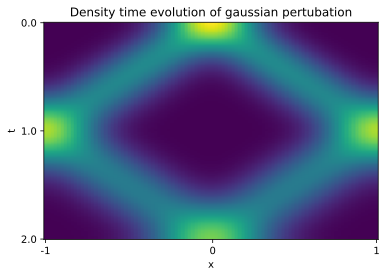

In [3]:
# Solving using the standard parameters.
N     = 100
q,x,t = isothermal_FV(N)

# Plotting time evolution of the density in a xt-diagram.
plt.imshow(q[:,0], aspect='auto')
plt.xticks(np.array([0,N/2,N-1]),[-1,0,1])
plt.xlabel('x')
n_ticks_t = 3
t_ticks   = np.round(np.linspace(0,len(t)-1, n_ticks_t)).astype(int)
plt.yticks(t_ticks, np.around(t[t_ticks], 2))
plt.ylabel('t')
plt.title('Density time evolution of gaussian pertubation')
plt.savefig('images/density_evo.pdf')

Here we can clearly see that the sound crossing time scale is $t_{c_s} = 2$, since this is the time it takes for the sound waves to reach the inital position again. This result makes sense, since we specified the sound speed to $c_s = 1$ and with the length of the domain being $L = 2$, we would expect $t_{c_s} \approx \frac{L}{c_s}$.

We solve the same problem once more for a total integration time of $T = 10 t_{c_s}$, and plot the density $\rho$ at each multiple of $t_{c_s}$ in time.

In [4]:
def density_comparison(q1, q2, t1, t2, x, fname):
    # Create subplot.
    fig, ax = plt.subplots(2,2, sharey='row')
    ax = ax.flatten()

    # Set sequential colormap
    cmap = 'viridis'
    colors = getattr(plt.cm, cmap)(np.linspace(0,1,11))

    # Plotting the density at each multiple of the sound crossing time. (CFL = 0.4)
    for i in range(11):
        ax[0].plot(x,q1[int(i*(len(t1)-1)/10),0], color=colors[i])
    ax[0].set_ylabel("$\\rho$")
    ax[0].set_title('CFL=0.4')
    ax[0].ticklabel_format(style='sci', scilimits=(0,0))
    
    # Plotting the density at each multiple of the sound crossing time. (CFL = 1.0)
    for i in range(11):
        ax[1].plot(x,q2[int(i*(len(t2)-1)/10),0], color=colors[i])
    ax[1].set_title('CFL=1.0')

    # Plotting density time evolution in xt-diagram. (CFL = 0.4)
    ax[2].imshow(q1[:,0], aspect='auto')
    ax[2].set_xlabel('x')
    ax[2].set_ylabel('t')

    # Plotting density time evolution in xt-diagram. (CFL = 1.0)
    ax[3].imshow(q2[:,0], aspect='auto')
    ax[3].set_xlabel('x')
    
    # Setting custom tickmarks.
    # Upper left
    plt.sca(ax[0])
    plt.xticks(np.array([-1,0,1]),[None,None,None])    
    
    # Upper right
    plt.sca(ax[1])
    plt.xticks(np.array([-1,0,1]),[None,None,None])

    # Lower left
    plt.sca(ax[2])
    plt.xticks(np.array([0,N/2,N-1]),[-1,0,1])   
    n_ticks_t = 3
    t_ticks   = np.round(np.linspace(0,len(t1)-1, n_ticks_t)).astype(int)
    plt.yticks(t_ticks, np.around(t1[t_ticks], 2))

    # Lower right
    plt.sca(ax[3])
    plt.xticks(np.array([0,N/2,N-1]),[-1,0,1])

    plt.savefig(f'{fname}.pdf')

In [5]:
def kinetic_comparison(q1, q2, t1, t2, fname):
    # Calculating the total kinetic energy, for the case with CFL=0.4
    rho1   = q1[:,0]
    u1     = q1[:,1]/q1[:,0]
    E_kin1 = np.sum(0.5*rho1*u1**2, axis=1)

    # Calculating the total kinetic energy, for the case with CFL=1.0
    rho2   = q2[:,0]
    u2     = q2[:,1]/q2[:,0]
    E_kin2 = np.sum(0.5*rho2*u2**2, axis=1)
        
    # Plotting time evolution for both cases.
    fig, ax = plt.subplots(2, sharex=True)
    ax[0].plot(t1, E_kin1, label='CFL=0.4')
    ax[1].plot(t2, E_kin2, label='CFL=1.0')

    # Plot settings
    ax[0].set_ylabel('$E_{kin}$')
    ax[0].legend(loc='upper right')
    ax[1].set_xlabel('$t$')
    ax[1].set_ylabel('$E_{kin}$')
    ax[1].legend(loc='upper right')
    plt.suptitle('Total kinetic energy $E_{kin}$ time evolution')

    plt.savefig(f'{fname}.pdf')

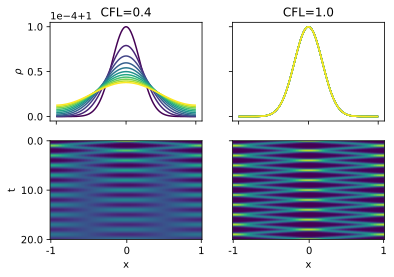

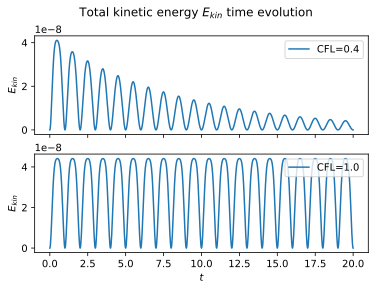

In [6]:
# Solve same problem for time up to T = 20, for CFL 1.0 and 0.4. 
N = 100; T = 20
q1,x,t1 = isothermal_FV(N, T, CFL=0.4)
q2,x,t2 = isothermal_FV(N, T, CFL=1.0)

# Plotting the time evolution
density_comparison(q1, q2, t1, t2, x, 'images/density_comp_100')
kinetic_comparison(q1, q2, t1, t2, 'images/kinetic_100')

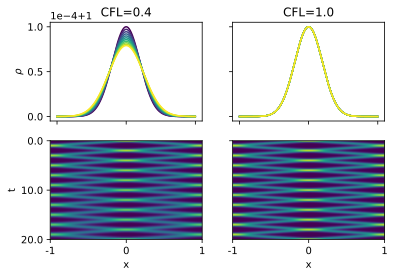

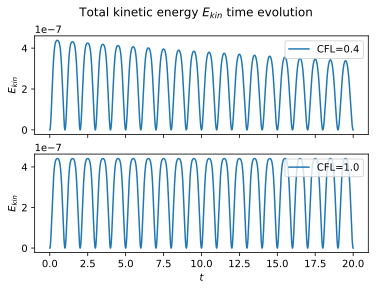

In [7]:
# Solve same problem for time up to T = 20, for CFL 1.0 and 0.4. 
N = 1000; T = 20
q1,x,t1 = isothermal_FV(N, T, CFL=0.4)
q2,x,t2 = isothermal_FV(N, T, CFL=1.0)

# Plotting the time evolution
density_comparison(q1, q2, t1, t2, x, 'images/density_comp_1000')
kinetic_comparison(q1, q2, t1, t2, 'images/kinetic_1000')

## 2. 1D Euler Riemann problem (13 pts)

In [8]:
def euler_riemann(N=100, T=0.2, CFL=0.4, rho_init=None, u_init=None, p_init=None):
    '''
    Solve the 1D isothermal hydrodynamic equations using HLL-based 
    finite volume solver. 
    
    Parameters:
    -----------
    N: int
        Number of cells in domain (excluding ghost cells).
    T: double
        Totalt time to integrate over. 
    CFL: double
        CFL-parameter.
    rho_init: function
        (Optional) function taking position vector x, specifies inital density.
    u_init: function
        (Optional) function taking position vector x, specifies inital velocity.
    p_init: function
        (Optional) function taking position vector x, specifies inital pressure.

    Returns:
    --------
    q: np.array shape=(N_timesteps, 2, N)
        Complete state vector at all cell positions, for all steps in time.
    x: np.array shape=(N,)
        Postion vector x corresponding to the cell centers with the domain.
    t: np.array shape=(N_timesteps,)
        Vector with positions in time, corresponding to solutions in q.
    '''
    # Parameters --------------------------------------------------------
    gamma = 1.4   # Adiabatic index. 
    x_min = 0     # Left domain edge.
    x_max = 1     # Right domain edge (x_min < x_max).
    
    # Inital conditions -------------------------------------------------
    # Use default initial conditions if none passed by user.
    if rho_init == None:
        def rho_init(x):
            return 1*(x<=0.5) + 0.125*(x>0.5)
    if p_init == None:
        def p_init(x):
            return 1*(x<=0.5) + 0.1*(x>0.5)
    if u_init == None:
        def u_init(x):
            return np.zeros_like(x)
    #--------------------------------------------------------------------
    # Cell size.
    dx = (x_max - x_min)/N 

    # Position vector (Including ghost cells).
    x = np.linspace(x_min-dx/2, x_max+dx/2, N+2)

    # Pre-allocate state vector.
    q = np.zeros((3,N+2))

    # Set inital conditions (with boundary conditions).
    q[0] = rho_init(x)
    q[1] = rho_init(x)*u_init(x)
    q[2] = p_init(x)/(gamma-1) + 0.5*rho_init(x)*u_init(x)**2

    # Euler flux function.
    def F(q):
        rhou2 = q[1]**2/q[0]
        P     = (gamma-1)*(q[2]-0.5*rhou2)
        return np.array([q[1], rhou2+P, q[1]/q[0]*(q[2]+P)])

    # HLL flux function. 
    def F_HLL(qL, qR, SL, SR):
        return (F(qL)*(SL>=0.) 
                + F(qR)*(SR<=0.) 
                + (SR*F(qL)-SL*F(qR)+SL*SR*(qR-qL))/(SR-SL)*((SL<0.)&(SR>0.)))

    # Create output lists.
    q_out = []
    t_out = []

    # Main simulation loop.
    t = 0
    while t < T:
        # Store state vector in output.
        q_out.append(q[:,1:-1].copy())
        t_out.append(t)
        
        # Estimate the sound speeds (at cell centers).
        P  = (gamma-1)*(q[2]-0.5*q[1]**2/q[0])
        cs = np.sqrt(gamma*P/q[0])
        
        # Update timestep size.
        u  = q[1]/q[0]
        dt = CFL*dx/(np.max(np.abs(u)) + np.max(cs))    

        # At all interfaces, get left and right states (constant recontruction).
        qL = q[:,:-1]  # len = N+1
        qR = q[:,1:]

        # Get wave speed estimates at cell interfaces.
        uLR = np.array([qL[1]/qL[0], qR[1]/qR[0]])
        SL = np.min(uLR, axis=0) - cs[:-1]
        SR = np.max(uLR, axis=0) + cs[1:]

        # Determine fluxes at interfaces.
        Flux = F_HLL(qL, qR, SL, SR)

        # Get residuals
        R = dt/dx * (Flux[:,1:]-Flux[:,:-1]) 

        # Update solutionin time (RK1)
        q[:,1:-1] -= R

        # Update time.
        t += dt

    # Convert output lists to arrays.
    q = np.array(q_out) 
    t = np.array(t_out)
    
    return q,x[1:-1],t

In [9]:
def plot_finalstate(q, x, t, N, fname):
    # Extract final states.
    gamma     = 1.4
    rho_final = q[-1,0]
    u_final   = q[-1,1]/q[-1,0]
    p_final   = (gamma-1)*(q[-1,2]-0.5*q[-1,1]**2/q[-1,0])

    # Plot final density, velocity and pressure.
    plt.figure()
    plt.plot(x, rho_final, label='Density $\\rho(x,t)$')
    plt.plot(x, u_final, label='Velocity $u(x,t)$')
    plt.plot(x, p_final, label='Pressure $P(x,t)$')

    # Plot settings 
    plt.legend()
    plt.title(f'Density, velocity and pressure profiles at\n' 
              f'time $t={{{np.around(t[-1],2)}}}$, with grid' 
              f' resolution $N = {{{N}}}$')
    plt.xlabel('x')
    plt.savefig(f'{fname}.pdf')

In [10]:
def plot_density_xt(q, x, t, N, fname):
    # Plotting time evolution of the density in a xt-diagram.
    plt.figure()
    plt.imshow(q[:,0], aspect='auto')

    # Plot settings
    plt.xlabel('x')
    plt.ylabel('t')
    n_ticks = 3
    t_ticks = np.round(np.linspace(0,len(t)-1, n_ticks)).astype(int)
    x_ticks = np.round(np.linspace(0,len(x)-1, n_ticks)).astype(int)
    plt.yticks(t_ticks, np.around(t[t_ticks], 2))
    plt.xticks(x_ticks, np.around(x[x_ticks], 1))
    plt.title(f'Density $\\rho(x,t)$ time evolution, $N = {{{N}}}$')
    plt.savefig(f'{fname}.pdf')

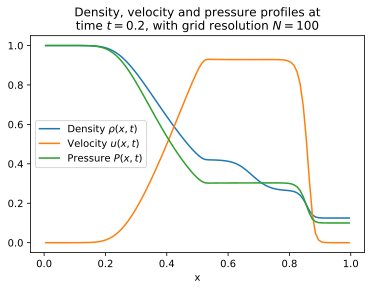

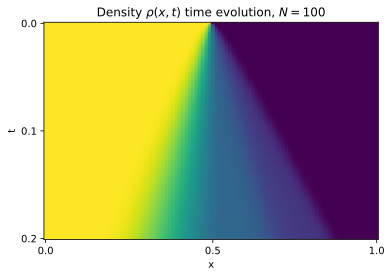

In [11]:
# Solving using the standard parameters.
N     = 100
q,x,t = euler_riemann(N)

# Plot results
plot_finalstate(q, x, t, N, 'images/final_100')
plot_density_xt(q, x, t, N, 'images/xt_100')

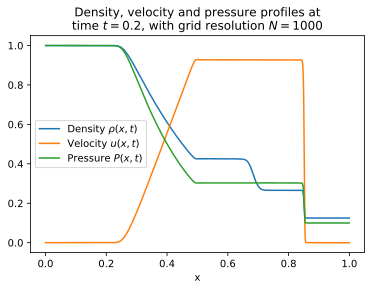

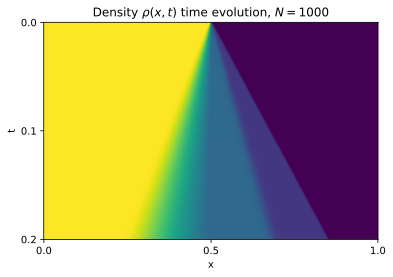

In [12]:
# Solving the previous problem using a higher resolution grid.
N     = 1000
q,x,t = euler_riemann(N)

# Plot results
plot_finalstate(q, x, t, N, 'images/final_1000')
plot_density_xt(q, x, t, N, 'images/xt_1000')

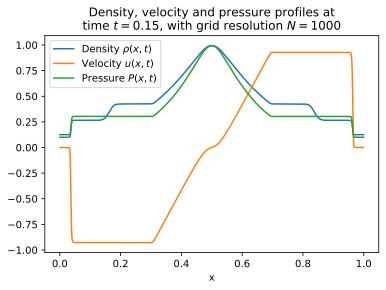

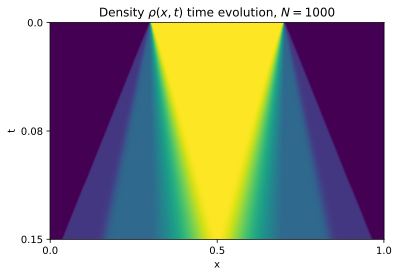

In [13]:
# Trying other inital conditions, to create double shock waves.
thres  = 0.2
center = 0.5
def rho_init2(x):
    return 1*(np.abs(x-center)<=thres) + 0.125*(np.abs(x-center)>thres)
def p_init2(x):
    return 1*(np.abs(x-center)<=thres) + 0.1*(np.abs(x-center)>thres)

# Solving the problem.
N     = 1000
T     = 0.15
q,x,t = euler_riemann(N=N, T=T, rho_init=rho_init2, p_init=p_init2)

# Plot the results
plot_finalstate(q, x, t, N, 'images/final_symmetric')
plot_density_xt(q, x, t, N, 'images/xt_1000_symmetric')